<a href="https://colab.research.google.com/github/Moriblo/MVP_Spt4_EngSoft/blob/main/MVP_SPT4_EngSoft_MLFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engenharia de Software - MVP Sprint 4

## Coleta de Dados

### _Requirements

In [330]:
!pip install gdown

In [331]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from google.colab import files
from IPython.display import display, HTML
from scipy import stats

### _Carga dos Datasets

In [332]:
# Informa a URL de importação do dataset
id_arquivo_1 = '1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG'
id_arquivo_2 = '1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD'
id_arquivo_cad = '1yO9-XahOdUOj00g9SyBBETASc84mRNtt'

# URLs para download direto dos arquivos
url_1 = f'https://drive.google.com/uc?id={id_arquivo_1}'
url_2 = f'https://drive.google.com/uc?id={id_arquivo_2}'
url_cad = f'https://drive.google.com/uc?id={id_arquivo_cad}'

# Faça o download dos arquivos
gdown.download(url_1, 'arquivo1.csv', quiet=False)
gdown.download(url_2, 'arquivo2.csv', quiet=False)
gdown.download(url_cad, 'arquivocad.csv', quiet=False)

# Lê o arquivo
df_1 = pd.read_csv('arquivo1.csv', delimiter=';')
df_2 = pd.read_csv('arquivo2.csv', delimiter=';')
df_cad = pd.read_csv('arquivocad.csv', delimiter=';')

# df_1 é o dataframe com os dados performance diária do mês M-1
# df_2 é o dataframe com os dados de performance diária do mês M
# df_cad é o dataframe com os dados de cadastro dos Fundos de Investimento

Downloading...
From: https://drive.google.com/uc?id=1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG
To: /content/arquivo1.csv
100%|██████████| 46.2M/46.2M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD
To: /content/arquivo2.csv
100%|██████████| 49.0M/49.0M [00:00<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yO9-XahOdUOj00g9SyBBETASc84mRNtt
To: /content/arquivocad.csv
100%|██████████| 3.59M/3.59M [00:00<00:00, 89.0MB/s]


## Pré-processamento

### _Limpeza

#### __Redundâncias

In [333]:
# Adequando VL_QUOTA à quantidade de casas decimais informada no Dicionário de Dados do
# dataset de origem
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(str).str.replace('.', '')
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(float)
df_1['VL_QUOTA'] = df_1['VL_QUOTA'] / (10**12)

df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(str).str.replace('.', '')
df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(float)
df_2['VL_QUOTA'] = df_2['VL_QUOTA'] / (10**12)

# Removendo as tuplas em que VL_QUOTA seja negativo (para efeito de cálculo de retorno)
df_1 = df_1[df_1["VL_QUOTA"] >= 0]
df_2 = df_2[df_2["VL_QUOTA"] >= 0]

####### AVALIANDO OS DADOS #######

# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_1.dtypes, columns=['df_1_dtypes'])
temp2 = pd.DataFrame(df_2.dtypes, columns=['df_2_dtypes'])
temp3 = pd.DataFrame(df_1.count(), columns=['df_1_count'])
temp4 = pd.DataFrame(df_2.count(), columns=['df_2_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp5 = pd.DataFrame([df_1.shape], columns=['df_1_rows', 'df_1_cols'])
temp6 = pd.DataFrame([df_2.shape], columns=['df_2_rows', 'df_2_cols'])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2, temp3, temp4], axis=1)

# Exibição do resultado
print(result)

# Exibição das informações de shape
print(temp5.to_string(index=False))
print(temp6.to_string(index=False))

display(df_1.describe())
display(df_2.describe())

              df_1_dtypes df_2_dtypes  df_1_count  df_2_count
TP_FUNDO           object      object      505152      536874
CNPJ_FUNDO         object      object      505152      536874
DT_COMPTC          object      object      505152      536874
VL_TOTAL          float64     float64      505152      536874
VL_QUOTA          float64     float64      505152      536874
VL_PATRIM_LIQ     float64     float64      505152      536874
CAPTC_DIA         float64     float64      505152      536874
RESG_DIA          float64     float64      505152      536874
NR_COTST            int64       int64      505152      536874
 df_1_rows  df_1_cols
    505152          9
 df_2_rows  df_2_cols
    536874          9


,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,5.051520e+05,5.051520e+05,5.051520e+05,5.051520e+05,5.051520e+05,5.051520e+05
mean,4.213980e+08,1.785431e+04,4.206399e+08,2.341868e+06,2.353635e+06,1.001893e+03
std,2.819297e+09,9.689061e+05,2.816258e+09,4.613030e+07,5.334481e+07,1.645567e+04
min,-4.555807e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.535371e+07,1.182997e+00,1.539842e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.306366e+07,2.119174e+00,4.316420e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.558318e+08,2.544611e+01,1.560282e+08,0.000000e+00,0.000000e+00,1.600000e+01
max,1.632093e+11,1.067943e+08,1.632091e+11,7.671206e+09,1.437241e+10,1.185455e+06


,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,5.368740e+05,5.368740e+05,5.368740e+05,5.368740e+05,5.368740e+05,5.368740e+05
mean,4.160074e+08,1.615053e+04,4.152680e+08,2.304712e+06,2.369199e+06,9.895581e+02
std,2.789516e+09,8.448188e+05,2.787043e+09,4.702319e+07,5.269102e+07,1.638518e+04
min,-3.073482e+08,0.000000e+00,-4.150969e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.481920e+07,1.165526e+00,1.484767e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.167161e+07,2.062146e+00,4.173578e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.512468e+08,2.493133e+01,1.513313e+08,0.000000e+00,0.000000e+00,1.500000e+01
max,1.606797e+11,1.065101e+08,1.606795e+11,1.276418e+10,1.423898e+10,1.195044e+06


#### __Missings

In [334]:
####### MARCANDO E PREENCHENDO OS DATAFRAMES  #######
# Considerando somente os dígitos de "dia" em relação a DT_COMPTC (Data de competência do
# documento)
df_1['DT_COMPTC'] = df_1['DT_COMPTC'].str.slice(0, 2)
df_2['DT_COMPTC'] = df_2['DT_COMPTC'].str.slice(0, 2)

# Definindo o index para o JOIN
df_1.set_index(['CNPJ_FUNDO', 'DT_COMPTC'], inplace=True)
df_2.set_index(['CNPJ_FUNDO', 'DT_COMPTC'], inplace=True)

# JOIN os dois DataFrames usando o índice
df_3 = df_2.join(df_1, rsuffix='_1')

# Resetar o índice
df_3.reset_index(inplace=True)

# Merge entre df_3 e df_cad para classificar os CNPJs em df_3 com sua respectiva classe de
# fundo obtida de df_cad.
df_3 = df_3.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')

# Calculando o retorno, dia a dia, do mês analisado (df_2) em relação ao mês anterior (df_1)
# na coluna RETORNO com cinco casas decimais
df_3['RETORNO'] = ((df_3['VL_QUOTA'] - df_3['VL_QUOTA_1']) / df_3['VL_QUOTA']).round(5)

In [335]:
####### FORMATANDO O DATAFRAME DE ATRIBUTOS (df_atrib) #######
df_atrib = df_3

# Mantém somente as colunas referentes ao mês corrente (M -> df_2)
df_atrib = df_atrib.filter(regex='[^_1]$')

# Considerando que RETORNO > 0, é um bom investimento (SUGESTÃO = 1), caso contrário não
# é um bom investimento (SUGESTÃO = 0)
df_atrib['SUGESTÃO'] = df_atrib['RETORNO'].apply(lambda x: 1 if x > 0 else 0)

# Limpa coluna RETORNO
df_atrib = df_atrib.replace(['#NOME?', '', '-Infinity'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])
df_atrib['RETORNO'] = df_atrib['RETORNO'].astype(str)
df_atrib = df_atrib.replace(['-Infinity', '-inf'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])

# Mantém somente os atributos empiricamente relevantes mais o atributo alvo calculado (SUGESTÃO)
df_atrib = df_atrib.reset_index()
df_atrib = df_atrib[['DT_COMPTC','CNPJ_FUNDO', 'TP_FUNDO', 'CLASSE', 'RESG_DIA', 'CAPTC_DIA', \
                     'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA', 'SUGESTÃO']]

In [336]:
####### AJUSTANDO ATRIBUTOS - NR_COTST #######
# Trabalhando sobre NR_COTST (Número de Cotistas). Escolheu-se focar em fundos com mais de
# 100 (cem) cotistas, para que se possa dar maior relevância à observação dos dados de
# captação e resgates diários.
df_atrib['NR_COTST'] = df_atrib['NR_COTST'].astype(int)
df_atrib = df_atrib[(df_atrib['NR_COTST'] > 100)]

In [337]:
####### AJUSTANDO ATRIBUTOS - CLASSE #######
# Trabalhando sobre CLASSE (Classe do Fundo)

# Filtrando os dados do dataframe para conter somente a CLASSE Fundo Multimercado
df_atrib = df_atrib[(df_atrib['CLASSE'] == "Fundo Multimercado")]

# Como só teremos a CLASSE Fundo Multimercado, não faz mais sentido mantermos este atributo
df_atrib = df_atrib[['DT_COMPTC','CNPJ_FUNDO', 'TP_FUNDO', 'RESG_DIA', 'CAPTC_DIA', 'NR_COTST', \
                     'VL_PATRIM_LIQ', 'VL_QUOTA', 'SUGESTÃO']]

#### __Outliers

In [339]:
####### TRATANDO OUTLIERS EM df_atrib  #######
# Lista de colunas para converter em string
colunas_para_converter = ['DT_COMPTC', 'CNPJ_FUNDO', 'TP_FUNDO', 'SUGESTÃO']

# Convertendo as colunas para string
for coluna in colunas_para_converter:
    df_atrib[coluna] = df_atrib[coluna].astype(str)

# Selecionando apenas colunas numéricas para calcular o Z-score
df_numeric = df_atrib.select_dtypes(include=[np.float, np.int])

""" Calculando o Z-score """
z = np.abs(stats.zscore(df_numeric))

# Removendo os outliers
df_atrib = df_atrib[(z < 3).all(axis=1)]

""" Calculando IQR """
Q1 = df_atrib.quantile(0.25)
Q3 = df_atrib.quantile(0.75)
IQR = Q3 - Q1

# Os outliers são então definidos como observações que estão abaixo de (Q1 - 1.5 * IQR)
# ou acima de (Q3 + 1.5 * IQR).
df_atrib = df_atrib[~((df_atrib < (Q1 - 1.5 * IQR)) | (df_atrib > (Q3 + 1.5 * IQR))).any(axis=1)]

# Mantidas somente as colunas numéricas
df_atrib = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA', 'SUGESTÃO']]

### _Apresentação dos Atributos

#### __Dados após LIMPEZA

In [340]:
# Criação de DataFrames temporários para armazenar os tipos de dados e contagens
temp1 = pd.DataFrame(df_atrib.dtypes, columns=['df_atrib_dtypes'])
temp2 = pd.DataFrame(df_atrib.count(), columns=['df_atrib_count'])

# Criação de DataFrames temporários para armazenar as informações de shape
temp3 = pd.DataFrame([df_atrib.shape], columns=['df_atrib_rows', 'df_atrib_cols'])

# Concatenação dos DataFrames lado a lado
result = pd.concat([temp1, temp2], axis=1)

# Exibição do resultado
print(result)

# Exibição das informações de shape
print(temp3.to_string(index=False))

display(df_atrib.describe())
display(df_atrib)

              df_atrib_dtypes  df_atrib_count
RESG_DIA              float64            9651
CAPTC_DIA             float64            9651
NR_COTST                int64            9651
VL_PATRIM_LIQ         float64            9651
VL_QUOTA              float64            9651
SUGESTÃO               object            9651
 df_atrib_rows  df_atrib_cols
          9651              6


,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,VL_QUOTA
count,9651.000000,9651.000000,9651.000000,9.651000e+03,9651.000000
mean,33911.360820,3702.269116,651.963320,8.744363e+07,3.770400
std,74840.408812,10530.068842,757.523364,1.119000e+08,5.204619
min,0.000000,0.000000,101.000000,2.426454e+05,0.121723
25%,0.000000,0.000000,163.000000,1.376688e+07,1.164588
50%,0.000000,0.000000,332.000000,4.081013e+07,1.394515
75%,23201.565000,100.000000,806.000000,1.190069e+08,3.001771
max,408038.070000,63000.000000,4055.000000,6.013991e+08,30.515222


,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,VL_QUOTA,SUGESTÃO
1233,165419.86,1000.00,1281,75763538.61,20.152076,0
1236,151711.57,47392.07,1281,75654194.17,20.150740,1
1239,59932.92,15977.96,1280,75696800.69,20.173796,1
1242,15437.21,0.00,1267,75638531.81,20.236531,1
1245,42787.90,0.00,1261,75463711.64,20.201207,0
...,...,...,...,...,...,...
301899,34.60,38037.00,186,5386874.49,8.773728,0
301902,290.54,5745.24,228,5451121.37,8.860838,0
301905,16.29,370.51,235,5565833.40,9.046727,0
301908,107.77,6229.71,247,5441814.77,8.835196,0


#### __Boxplot

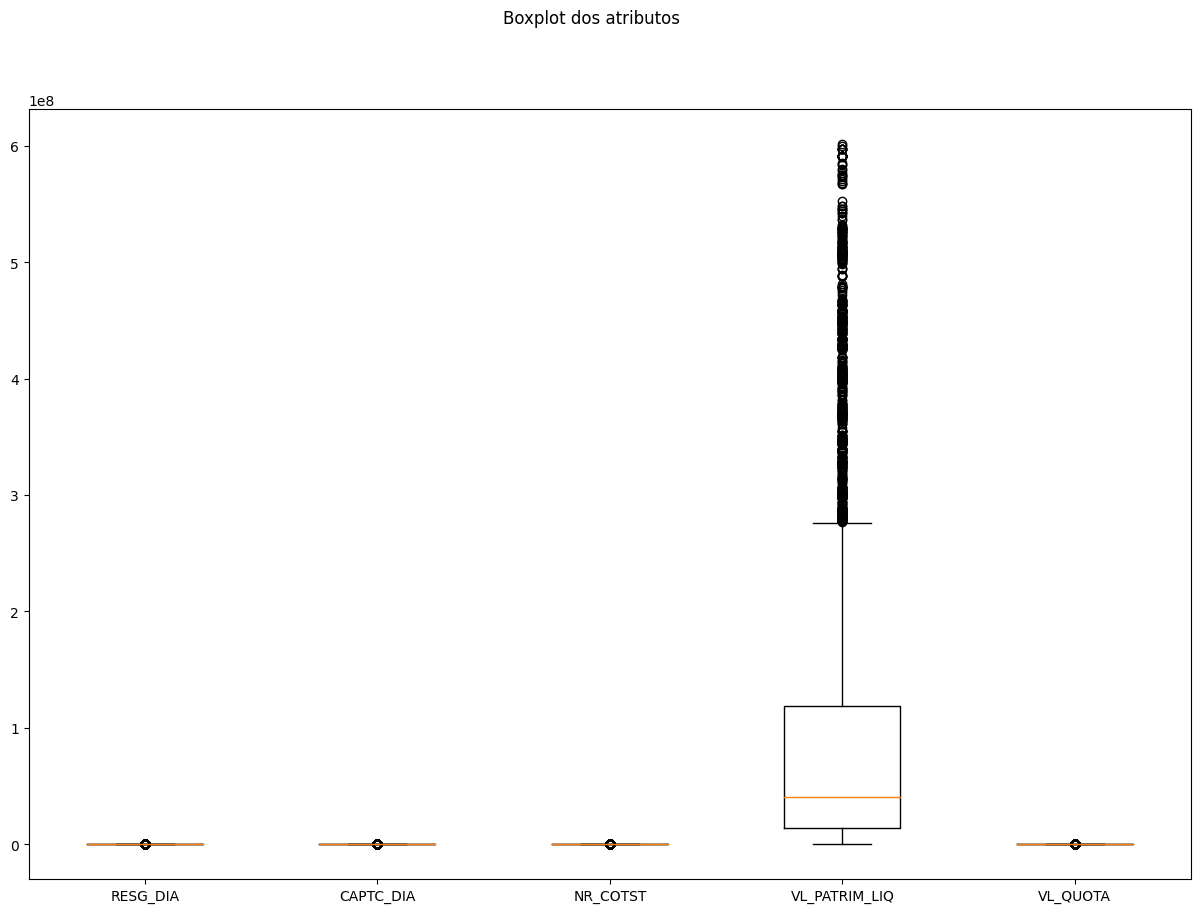

In [341]:
# Boxplot dos atributos
df_box = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']]
names = ('RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA')

fig = plt.figure(figsize=(15,10))
fig.suptitle('Boxplot dos atributos')
ax = fig.add_subplot(111)
plt.boxplot(df_box)
ax.set_xticklabels(names)
plt.show()

#### __Linear

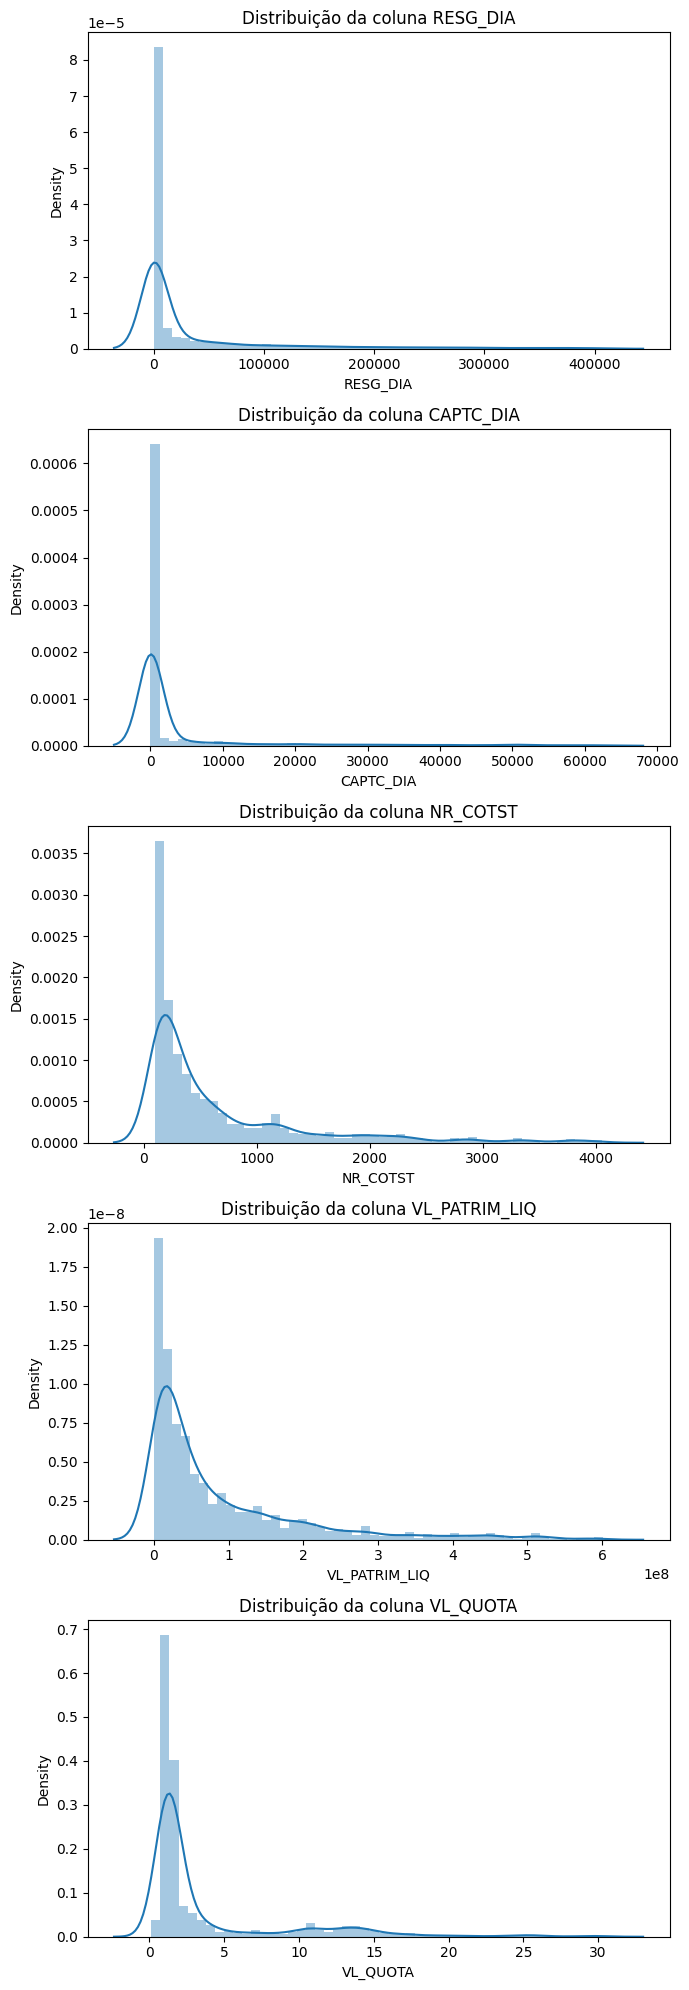

In [342]:
# Distribuíção Linear
# Lista das colunas que você deseja visualizar
cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']

# Cria uma figura com 5 subplots
fig, axs = plt.subplots(5, figsize=(7, 20))

# Para cada coluna, cria um gráfico de distribuição linear
for i, col in enumerate(cols):
    sns.distplot(df_atrib[col], ax=axs[i])
    axs[i].set_title('Distribuição da coluna {}'.format(col))

plt.tight_layout()
plt.show()

### _Separação em conjunto de treino e conjunto de teste com holdout

In [327]:
####### DEFININDO PARÂMETROS DO CONJUNTO DE TESTES #######

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_atrib.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

#>>>>>>> DEPOIS DA SEPARAÇÃO EM CONJUNTO DE TREINO E TESTE, DEVE SER FEITA A NORMALIZAÇÃO CASO NECESSÁRIO <<<<<<<


In [ ]:
""" ### DADOS DO BING ###
# Definindo o tamanho do conjunto de teste e a semente aleatória
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste
array = df_atrib.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Média = {cv_results.mean()}, Desvio padrão = {cv_results.std()}")
"""

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.628497 (0.024211)
CART: 0.825130 (0.013696)
NB: 0.549741 (0.013857)
SVM: 0.547539 (0.004743)


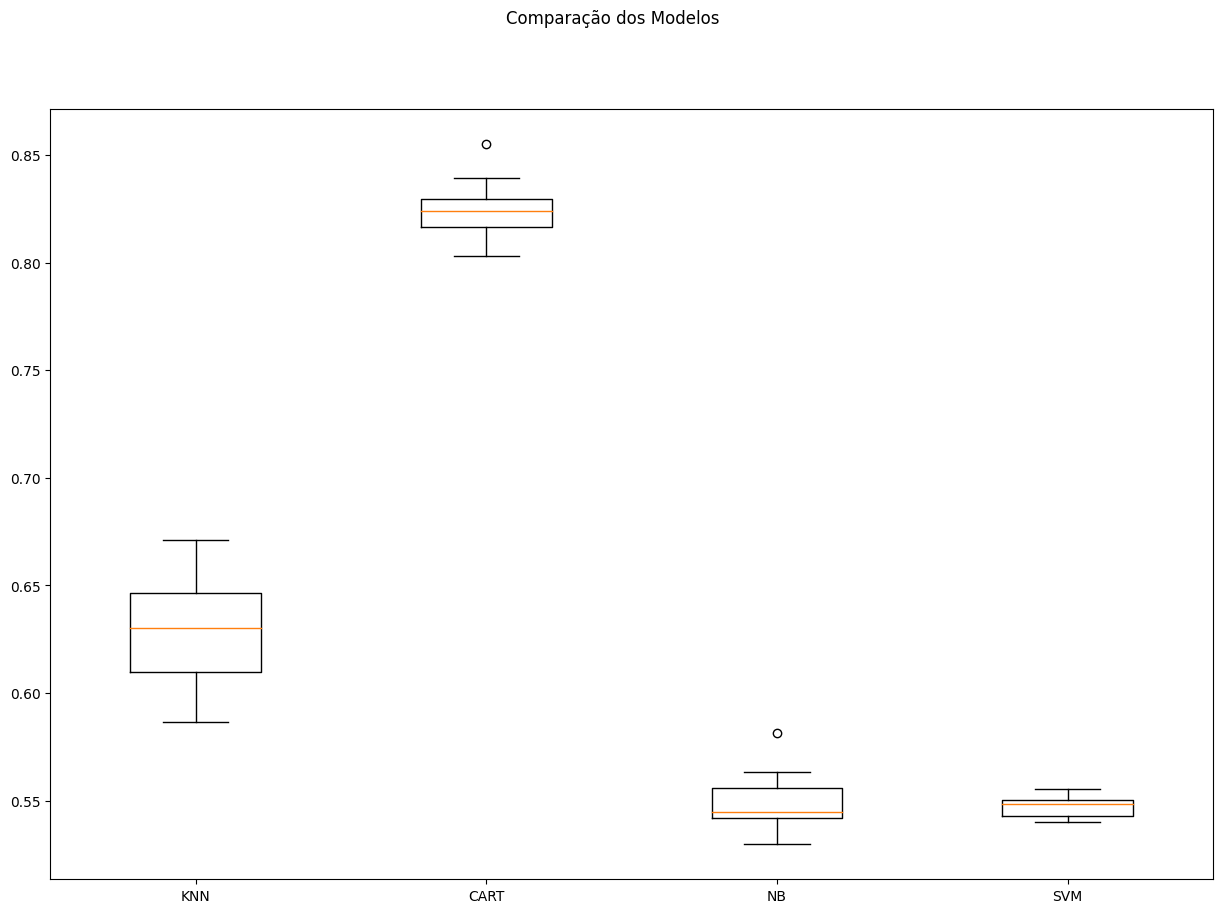

In [328]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.554 (0.014)
CART-orig: 0.808 (0.015)
NB-orig: 0.556 (0.014)
SVM-orig: 0.552 (0.013)
KNN-padr: 0.593 (0.012)
CART-padr: 0.808 (0.018)
NB-padr: 0.556 (0.014)
SVM-padr: 0.597 (0.013)
KNN-norm: 0.579 (0.014)
CART-norm: 0.806 (0.018)
NB-norm: 0.556 (0.014)
SVM-norm: 0.580 (0.011)


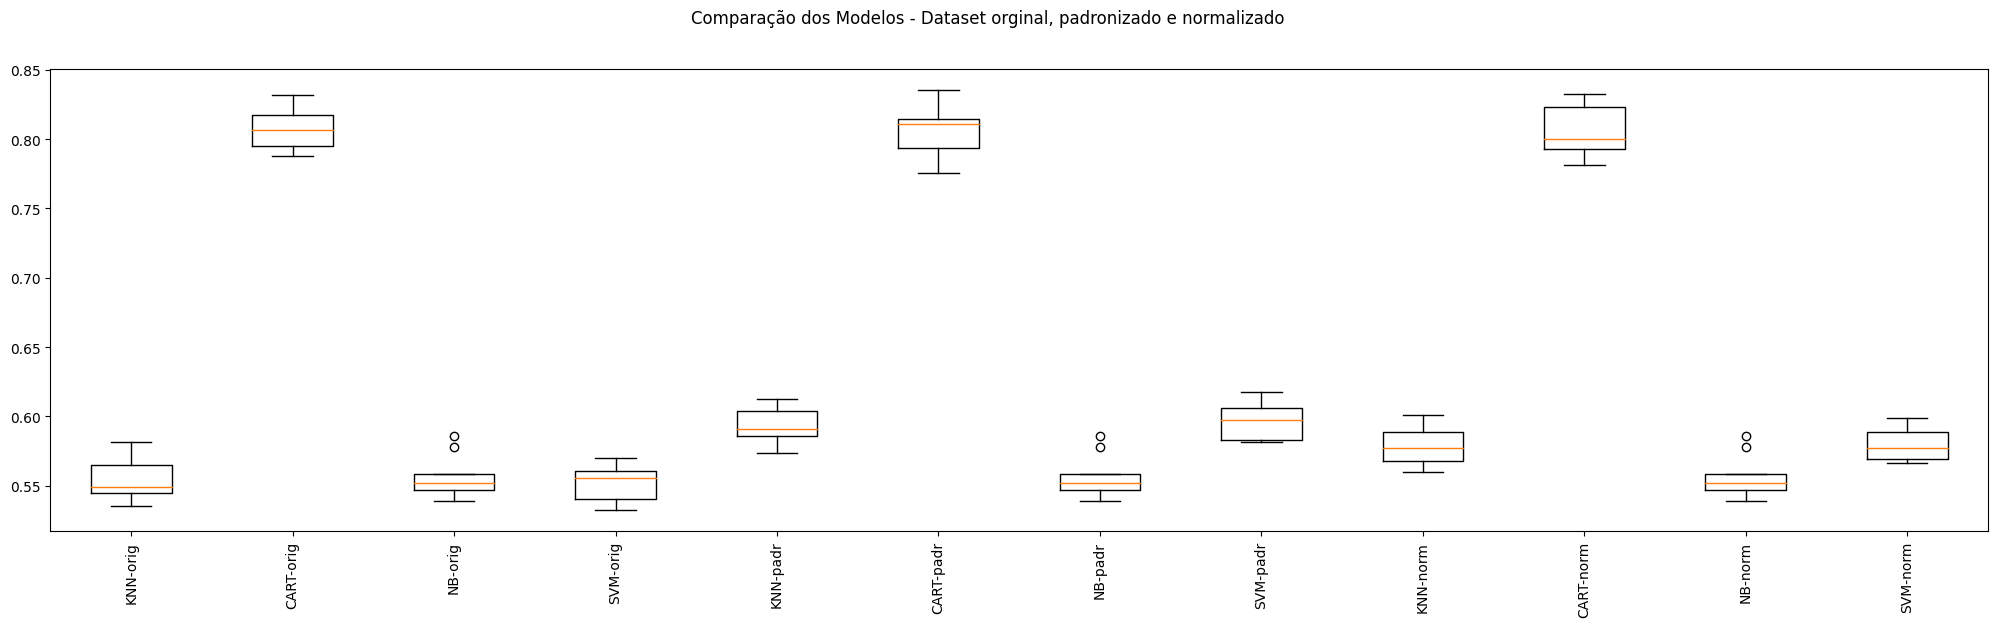

In [245]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [246]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.579016 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 21}
Sem tratamento de missings: knn-padr - Melhor: 0.629793 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
Sem tratamento de missings: knn-norm - Melhor: 0.602979 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}


## Finalização do Modelo

In [247]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.6162610046607975


In [248]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

## Simulando a aplicação do modelo em dados não vistos

In [249]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

ValueError: ignored

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)